## Example usage of the gridcell package

In [1]:
%matplotlib inline

### Importing from files

We will use recorded data stored in the file ``../data/FlekkenBen.mat``. We have to manually work through this file and present the data it contains in a way that the ``gridcell`` package can understand. To this end, functions from the ``transform`` module may come in handy, both for formatting the data and transforming it to axes we want to use.

In [2]:
# Select data source
datafile = '../../data/FlekkenBen/data.mat'

# Load raw data from file
from scipy import io

raw_data = io.loadmat(datafile, squeeze_me=True)
#print(raw_data)

# Create sessions dict from the data
from gridcell import transform

positions = [pos.T for pos in raw_data['allpos']]
spike_times = raw_data['allst']
data = transform.sessions(positions, spike_times)

# Transform axes
tight_range = ((-74.5, 74.5), (-74.5, 74.5))
data = transform.transform_sessions(data, global_=False,
                                    range_=tight_range,
                                    translate=True, rotate=True)

### Setting up the CellCollection

The representation of the data provided by ``data`` is just a temporary interface. The functionality of the package is provided mainly through a class ``Cell`` representing the cells, and a container class ``CellCollection`` representing several cells. The standardized dataset representation from `transform.session` can be used to initialize an instance of ``CellCollection``, creating ``Cell`` instances for each cell in the process.

In [3]:
# Define the binning of the experimental environment
bins = (50, 50)
range_ = ((-75.0, 75.0), (-75.0, 75.0))

# Set filter parameters (use the same length unit as range_,
# and the same time unit as in the raw data)
speed_window = 0.5
min_speed = 3.0
position_kw = dict(speed_window=speed_window, min_speed=min_speed)

filter_size = 150.0 / 50
threshold = 0.2  # Only a default
cell_kw = dict(filter_size=filter_size, threshold=threshold)

# Instantiate CellCollection
from gridcell import CellCollection

cells = CellCollection.from_multiple_sessions(
    data, bins, range_, position_kw=position_kw, cell_kw=cell_kw)

print("Number of cells: {}".format(len(cells)))

Number of cells: 176


Note that the ``CellCollection.from_multiple_sessions`` constructor takes a number of arguments affecting different aspects of the analysis. See the documentation for details.

### Plotting and iterating the parameters

In [4]:
# To improve on the matplotlib aesthetics, we import the seaborn
# library and choose some nice colormaps
import seaborn
seaborn.set(rc={'figure.facecolor': '.98', 'legend.frameon': True})
ratecmap = 'YlGnBu_r'
corrcmap = 'RdBu_r'

Now, lets take a look at what we just created. The ``CellCollection`` instance can be accessed (and modified) like a list.

In [5]:
# Select a cell to have a closer look at
cell = cells[109]

Let's begin by plotting the raw data -- the path of the rat, with the spike locations of this cell superimposed.

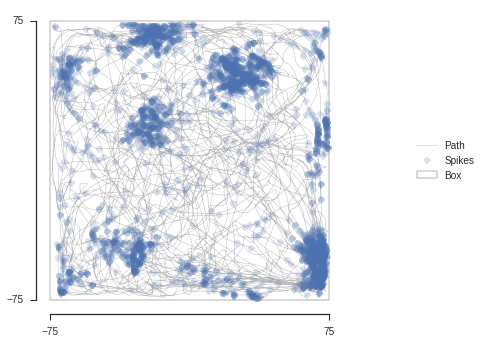

In [6]:
# Create a square patch representing the experimental environment
from matplotlib import patches
xmin, xmax = range_[0]
ymin, ymax = range_[1]
dx, dy = xmax - xmin, ymax - ymin
box = patches.Rectangle((xmin, ymin), dx, dy,
                        fill=False, label="Box")

# Plot the path and spikes
with seaborn.axes_style('ticks'):
    path = cell.position.plot_path(label='Path')[0]
    axes = path.get_axes()
    cell.plot_spikes(axes=axes, alpha=0.2, label='Spikes')
    axes.add_patch(box)
    axes.set(xlim=[xmin - 0.05 * dx, xmax + 0.55 * dx],
             ylim=[ymin - 0.05 * dy, ymax + 0.05 * dy],
             xticks=[xmin, xmax], yticks=[xmin, xmax])
    axes.legend(loc=5)
    seaborn.despine(offset=0, trim=True)

That looks promising. Let's plot the firing rate map. This map has been passed through a smoothing filter with filter size given by the parameter ``filter_size`` in the ``CellCollection`` instantiation.

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


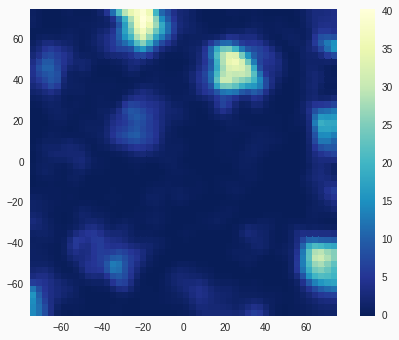

In [7]:
cell.plot_ratemap(cmap=ratecmap)

This definitely looks like a grid cell, with a firing fields spread out in a nice pattern. However, the difference in firing field strength is substantial. Let's see how the autocorrelogram looks.

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


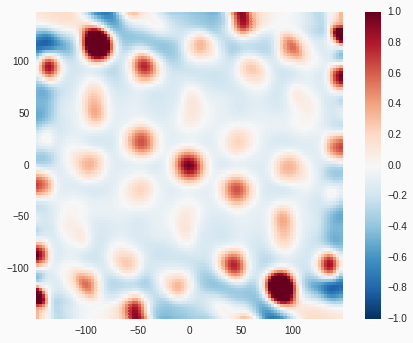

In [8]:
cell.plot_acorr(cmap=corrcmap)

Pretty nice. But how does the default threshold work with those weak peaks?

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


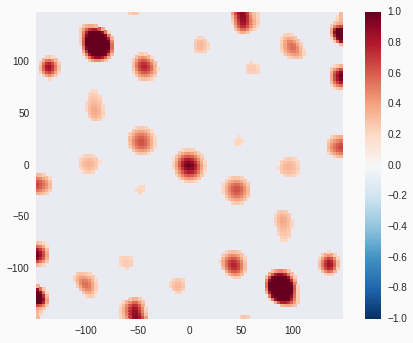

In [9]:
cell.plot_acorr(cmap=corrcmap, threshold=True)

Two of the peaks are to low for this threshold. Let's find out what the threshold for this cell should be, assuming as a rule that the threshold should be as close as possible to the default value (0.20), while allowing all the six inner peaks to be identified and separated from each other and background noise, with at least four pixels per peak above the threshold.

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


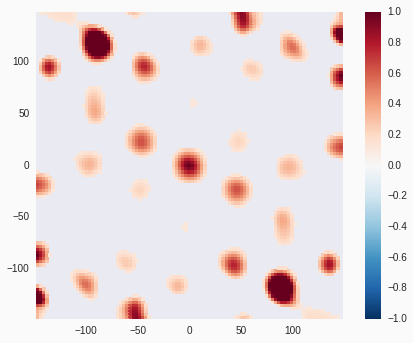

In [10]:
cell.plot_acorr(cmap=corrcmap, threshold=0.12)

That's it! We had to go all the way down to 0.12 to get the required four pixels per peak. Let's update the ``'threshold'`` parameter of the cell to reflect this

In [11]:
cells[109].params['threshold'] = 0.12

We should check that the problem has been fixed:

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


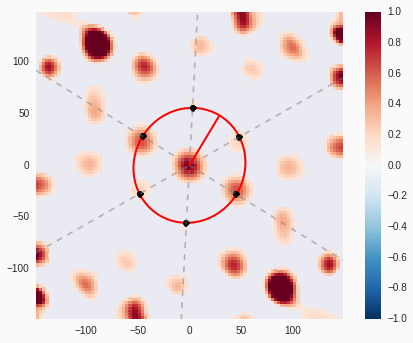

In [12]:
cell.plot_acorr(cmap=corrcmap, threshold=True,
                grid_peaks=True, grid_ellipse=True)

Notice how the detected peak centers, and the ellipse fitted through them, were added using the keywords ``grid_peaks`` and ``grid_ellipse``. These keywords are provided for convenience, and uses hardcoded defaults for the appearance of the peaks and ellipse. For more fine grained control, use the ``plot_grid_peaks`` and ``plot_grid_ellipse`` methods of the ``Cell`` instance instead. 

/home/daniel/anaconda3/envs/atlas/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


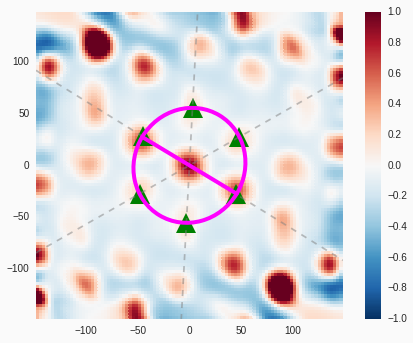

In [13]:
cell.plot_acorr(cmap=corrcmap, threshold=False)
cell.plot_grid_peaks(marker='^', color='green', markersize=20)
cell.plot_grid_ellipse(smajaxis=False, minaxis=True, color='magenta',
                       linewidth=4, zorder=3)

In [14]:
# There are other cells requiring custom thresholds
cells[0].params['threshold'] = 0.17
cells[8].params['threshold'] = 0.31
cells[13].params['threshold'] = 0.21
cells[31].params['threshold'] = 0.11
cells[40].params['threshold'] = 0.08
cells[43].params['threshold'] = 0.09
cells[59].params['threshold'] = 0.18
cells[63].params['threshold'] = 0.27
cells[80].params['threshold'] = 0.18
cells[82].params['threshold'] = 0.16
cells[98].params['threshold'] = 0.19
cells[109].params['threshold'] = 0.12
cells[118].params['threshold'] = 0.40  # Or just 0.20
cells[128].params['threshold'] = 0.22
cells[129].params['threshold'] = 0.17
cells[133].params['threshold'] = 0.22
cells[150].params['threshold'] = 0.10
cells[153].params['threshold'] = 0.19
cells[159].params['threshold'] = 0.17
cells[160].params['threshold'] = 0.19
cells[161].params['threshold'] = 0.19
cells[162].params['threshold'] = 0.16
cells[168].params['threshold'] = 0.45  # Or 0.64

del cells[146]  # Won't work using the default settings

### Clustering and modules

The next step is to try to cluster the cells into modules. There are several clustering algorithms available for this purpose. Here, we use the K-means algorithm, implemented using the ``k_means`` function from ``scikit-learn``. We anticipate 4 modules.

In [15]:
# Find modules among the cells
# The grid scale is weighted a little more than the other features
# when clustering
feat_kw = dict(weights={'logscale': 2.5})
k_means_kw = dict(n_clusters=4, n_runs=10, feat_kw=feat_kw)

# We expect 4 modules
from gridcell import Module
labels = cells.k_means(**k_means_kw)
modules, outliers = Module.from_labels(cells, labels)

All clustering methods have a common return signature: ``modules, outliers``. The variable ``modules`` is a list containing a ``Module`` instance for each of the detected modules. ``Module`` is a subclass of ``CellCollection``, implementing some extra module-specific functionality for analyzing the phases of the cells in the module. The variable ``outliers`` is a CellCollection instance containing the cells that were not assigned to any module. When using the K-means algorithm, all cells are assigned to a module, so ``outliers`` is empty.

Let's take a look at the clustering by plotting the scales, orientation angles and ellipse parameters of the cells in each module next to each other.

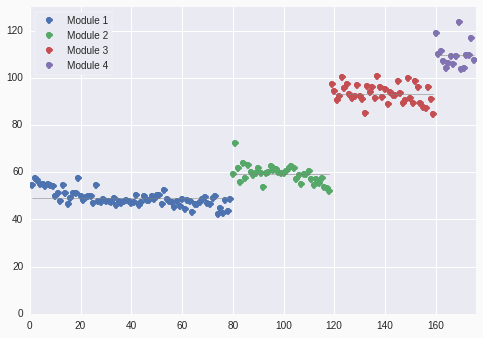

In [16]:
for (i, mod) in enumerate(modules):
    line = mod.plot_features(('scale',), label="Module {}".format(i + 1))[0]
axes = line.get_axes()
axes.set_ylim(bottom=0.0)
axes.legend(loc=0)

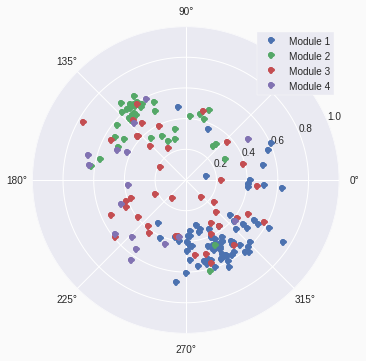

In [17]:
for (i, mod) in enumerate(modules):
    line = mod.plot_ellpars(label="Module {}".format(i + 1))[0]
axes = line.get_axes()
axes.legend(loc=0)

This walkthrough has demonstrated only some of the capabilities of the gridcell package. To find out more, read the docstrings in the code.